# Hierarchical coin flips

In this notebook we explore several different inference methods that are provided by Blackjax.

We define a hierarchical coin flip model. The mode of the prior on all coin flip probabilities of landing heads, $\omega$, is drawn from a beta distribution. The individual coins are beta distributed with $\omega$ as their mode and $\kappa$ as concentration. To transform $\omega,\kappa$ into beta parameters $a,b$ we need a link function.

$$
\begin{align*}
    \kappa &= 10\\
    \omega &\sim \text{beta}(10, 1)\\
    a_\theta &= \omega(\kappa-2) + 1\\
    b_\theta &= (1-\omega)(\kappa-2) + 1\\
    \theta_j &\sim \text{beta}(a_\theta, b_\theta) \\
    y_{ij} &\sim \text{Bernoulli}(\theta_i) \enspace,
\end{align*}
$$

where $j=1, \ldots, m$ are the number of coins, and $i=1, \ldots, n$ the (shared) number of coin flips per coin.

In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '3'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [3]


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
from jax.scipy.stats import gaussian_kde
import distrax as dx
import blackjax
from blackjax.diagnostics import effective_sample_size

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import sys

from bamojax.base import Model
from bamojax.samplers import gibbs_sampler, mcmc_sampler
from bamojax.inference import MCMCInference, SMCInference

print('Python version:     ', sys.version)
print('Jax version:        ', jax.__version__)
print('BlackJax version:   ', blackjax.__version__)
print('Distrax version:    ', dx.__version__)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Python version:      3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:         0.4.35
BlackJax version:    1.2.4
Distrax version:     0.1.5
Jax default backend: gpu
Jax devices:         [CudaDevice(id=0)]


# Modelling in bamojax 

## Nodes
A node can be one of three types:

1. A stochastic, latent node. This implies it is provided a `distribution` parameter.
2. A stochastic, observed node. This implies it is provided a `distribution` parameter, but also `observations`. 
3. A deterministic, observed node. This implies the node is _not_ provided a distribution parameter.

## Distributions

Distributions can be instantiated concrete distrax.Distribution objects, such as `dx.Beta(alpha=1, beta=1)`. Alternatively, the distribution is an uninstantiated object like `dx.Beta`. In the latter case, the `parents` of the node provide the input arguments to the distribution object.

## Parents

The `parents` argument is a dictionary with parameter names as keys, and `Node` or concrete `Array` objects as values. In the example below, the `parents` of `theta` are both the variable `omega` and the concrete value 15 for parameter `conc`. The latter is implemented by bamojax by creating an additional deterministic, observed node called `conc_theta` with `observations=15`.

Note that the keys omega and conc do not match the required parameters for a Beta distribution (in distrax, these should receive parameters alpha and beta). The link function `mode2ab` is a reference to a function that rewrites the arguments `mode` and `conc` into `alpha` and `beta`, and returns this as a new dictionary.

This is also needed for the Bernoulli distribution, as in distrax it can be parametrized either by probabilities or their logits, and it needs to be passed as an explicit keyword which of the two is used.

In [3]:
key = jrnd.PRNGKey(42)
# link functions take parent names and transform them into the kwargs for the child distribution.
def mode2ab(mode, conc):
    a = mode*(conc-2) + 1
    b = (1 - mode)*(conc-2) + 1
    return {'alpha': a, 'beta': b}

#
def theta2probs(probs):
    return {'probs': probs}

#

mode = 0.8
conc = 15
abdict = mode2ab(mode, conc)
a = abdict['alpha']
b = abdict['beta']
m = 10
n = 200

key, key_theta, key_y = jrnd.split(key, 3)
thetas = dx.Beta(alpha=a, beta=b).sample(seed=key_theta, sample_shape=(m, ))
ys = 1.0*dx.Bernoulli(probs=thetas).sample(seed=key_y, sample_shape=(n, ))

HierarchicalCoinflips = Model('hcf')
omega = HierarchicalCoinflips.add_node('omega', distribution=dx.Beta(alpha=10.0, beta=1.0))
theta = HierarchicalCoinflips.add_node('theta', distribution=dx.Beta, parents=dict(mode=omega, conc=15), link_fn=mode2ab, shape=(m, ))
y = HierarchicalCoinflips.add_node('y', distribution=dx.Bernoulli, parents=dict(probs=theta), observations=ys, link_fn=theta2probs, shape=(n, ))

print('Gibbs conditionals: ')
HierarchicalCoinflips.print_gibbs()

Gibbs conditionals: 
Gibbs structure:
omega               : p(theta | omega, conc_theta) p(omega)
theta               : p(y | theta) p(theta | omega, conc_theta)


Plotting functions for the toy model posterior:

In [4]:
import numpy as np
def plot_posterior(samples, colormap, title):
    if jnp.ndim(samples['theta']) > 2:
        num_chains = samples['theta'].shape[0]
        colors = np.flip(colormap(np.linspace(0.3, 1, num_chains)), axis=0)
    else:
        num_chains = 1
        colors = colormap(0.5)

    fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(18, 3))
    ax = axes[0]
    ax.plot([0, 1], [0, 1], ls='--', color='k', zorder=-5)
    if num_chains > 1:
        for c in range(num_chains):
            ax.scatter(thetas, jnp.mean(samples['theta'][c, ...], axis=0), s=60, edgecolors='k', color=tuple(colors[c, ...]))
    else:
        ax.scatter(thetas, jnp.mean(samples['theta'], axis=0), s=60, edgecolors='k', color=tuple(colors))
    ax.set_xlabel(r'True $\theta$')
    ax.set_ylabel(r'$\mathbb{E}[p(\theta\mid D)]$')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1]);

    ax = axes[1]
    omega_lims = [0.6, 0.95]
    omega_range = jnp.linspace(*omega_lims, num=100)
    if num_chains > 1:
        for c in range(num_chains):
            smpls = samples['omega'][c, ...]
            pdf = gaussian_kde(smpls)
            y_ = pdf(omega_range)
            ax.fill_between(omega_range, y_, jnp.zeros_like(y_), color=tuple(colors[c, ...]), alpha=0.7)
            ax.plot(omega_range, y_, color='k', lw=0.5)
    else:
        smpls = samples['omega']
        pdf = gaussian_kde(smpls)
        y_ = pdf(omega_range)
        ax.fill_between(omega_range, y_, jnp.zeros_like(y_), color=tuple(colors), alpha=0.7)
        ax.plot(omega_range, y_, color='k', lw=0.5)

    ax.axvline(x=mode, ls='--', color='k')
    ax.set_ylim(bottom=0)
    ax.set_xlim(*omega_lims)
    ax.set_xlabel(r'$\omega$')

    ax = axes[2]
    if num_chains > 1:
        for c in range(num_chains):
            ax.plot(samples['omega'][c, ...], color=tuple(colors[c, ...]))
    else:
        ax.plot(samples['omega'], color=tuple(colors))
    ax.axhline(y=mode, ls='--', color='k')
    if num_chains > 1:
        ax.set_xlim([0, samples['omega'].shape[1]])
    else:
        ax.set_xlim([0, samples['omega'].shape[0]])
    ax.set_xlabel('Sample index')
    ax.set_ylabel(r'$\omega$')

    plt.suptitle(title)
    return fig, axes

#

## Standard MCMC

Effective sample sizes for RMH
ESS (omega): 3080.31
ESS (theta): 5539.18
Effective sample sizes for HMC
ESS (omega): 2.27
ESS (theta): 543.05
Effective sample sizes for Gibbs
ESS (omega): 16148.46
ESS (theta): 5689.88
Adapting NUTS HMC parameters... done.
Effective sample sizes for NUTS
ESS (omega): 41363.77
ESS (theta): 40010.93


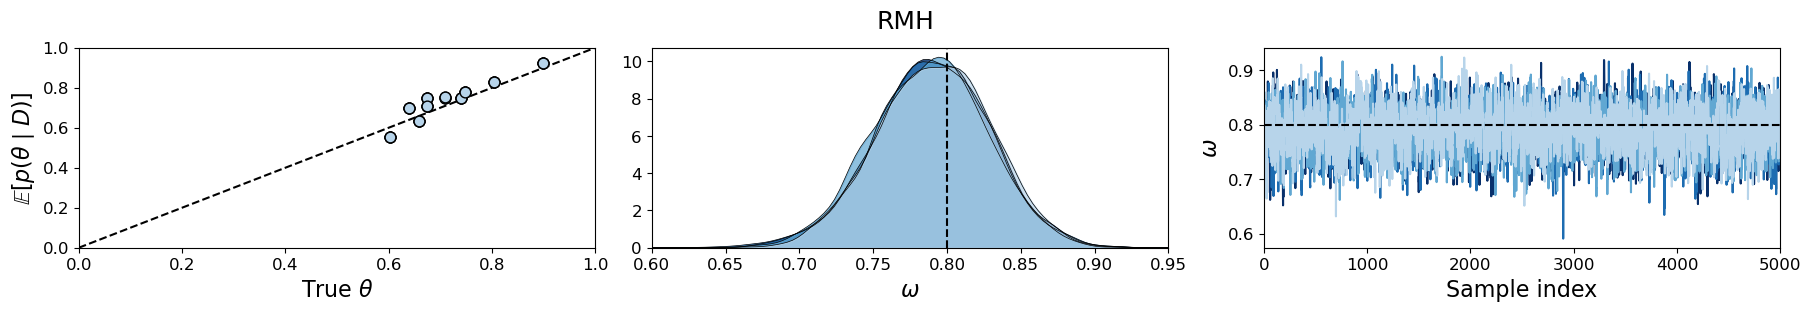

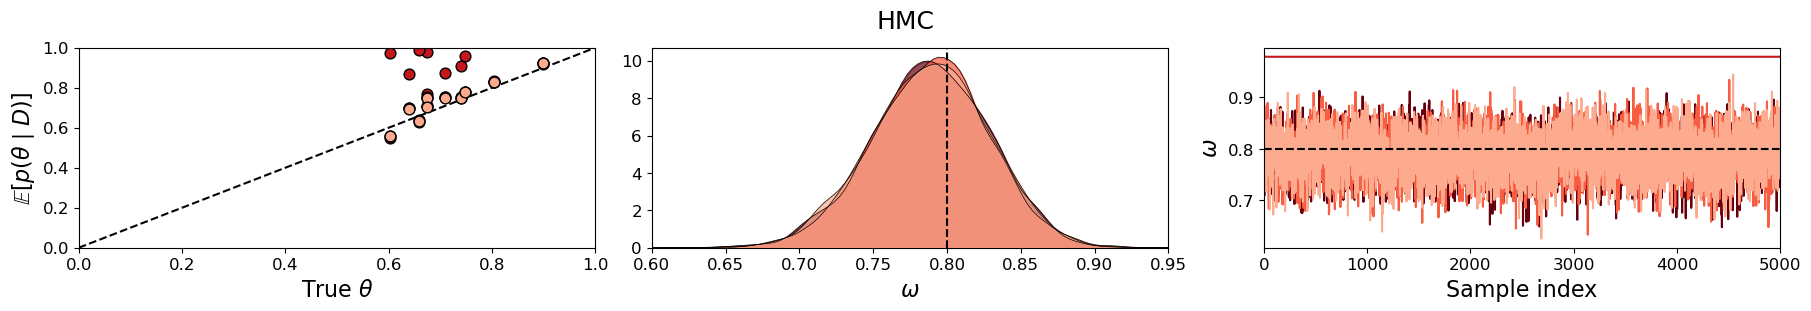

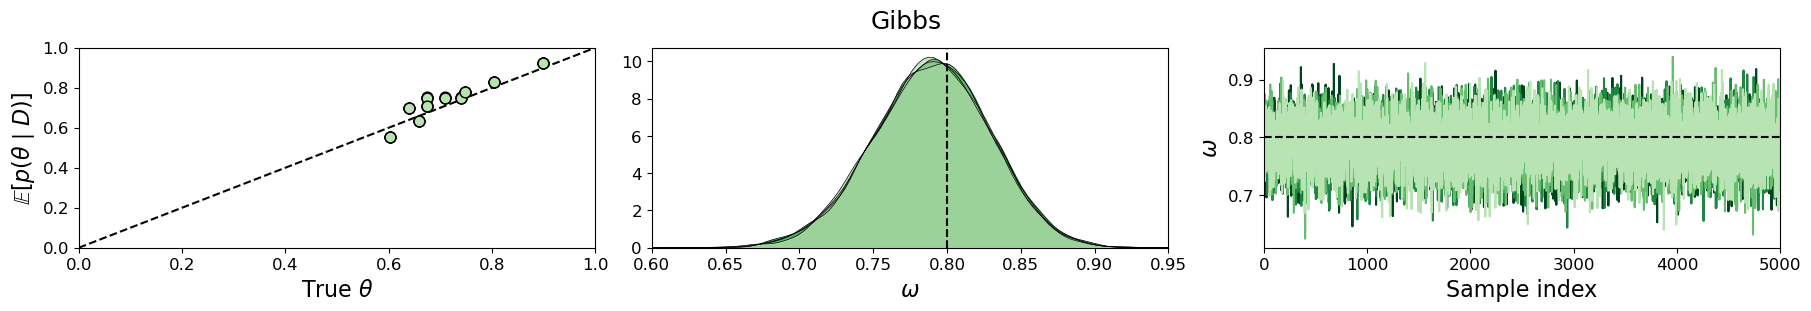

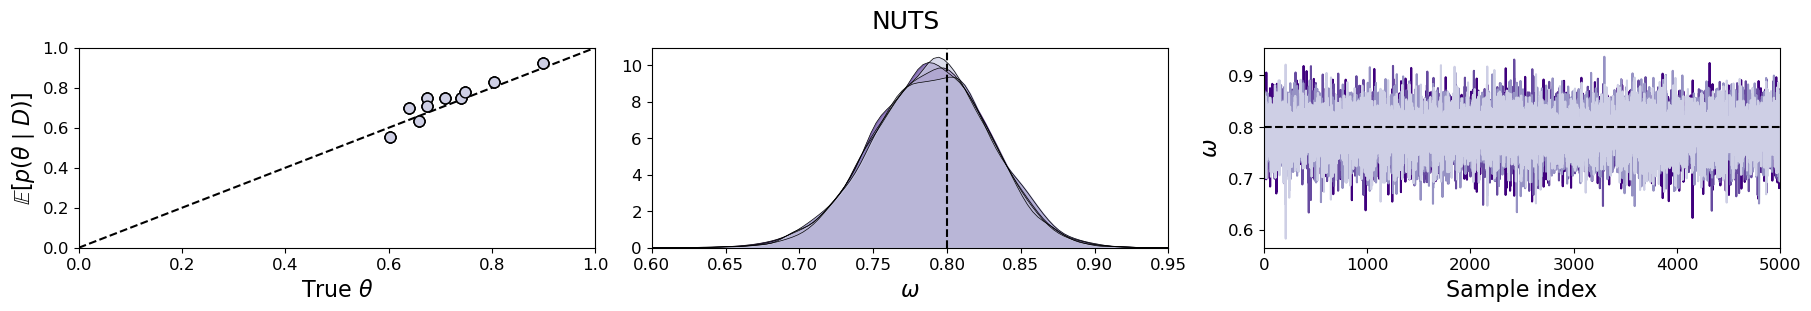

In [5]:
model = HierarchicalCoinflips
m = model.get_model_size()

### RMH
rmh_parameters = dict(sigma=0.02*jnp.eye(m))
rmh_kernel = mcmc_sampler(mcmc_kernel=blackjax.normal_random_walk, model=model, mcmc_parameters=rmh_parameters)

### HMC
num_integration_steps = 20  
stepsize = 0.01  
inverse_mass_matrix = 1.0*jnp.eye(m) 
hmc_parameters = dict(step_size=stepsize, inverse_mass_matrix=inverse_mass_matrix, num_integration_steps=num_integration_steps)
hmc_kernel = mcmc_sampler(model=model, mcmc_kernel=blackjax.hmc, mcmc_parameters=hmc_parameters)

### Gibbs
step_fns = dict(omega=blackjax.normal_random_walk, theta=blackjax.normal_random_walk)
step_fn_params = dict(omega=dict(sigma=0.1), theta=dict(sigma=0.02))
gibbs_kernel = gibbs_sampler(model, step_fns=step_fns, step_fn_params=step_fn_params)

### NUTS
cold_nuts_parameters = dict(step_size=0.5, inverse_mass_matrix=0.0001*jnp.eye(m))
nuts_kernel = mcmc_sampler(model=model, mcmc_kernel=blackjax.nuts, mcmc_parameters=cold_nuts_parameters)


mcmc_names = ['RMH', 'HMC', 'Gibbs', 'NUTS']
mcmc_kernels = [rmh_kernel, hmc_kernel, gibbs_kernel, nuts_kernel]

num_chains = 4
mcmc_settings = [dict(num_samples=50_000, num_burn=50_000, num_thin=10),
                 dict(num_samples=5_000, num_burn=1_000, num_thin=1),
                 dict(num_samples=50_000, num_burn=10_000, num_thin=10),
                 dict(num_samples=5_000, num_burn=0, num_warmup=1_000, num_thin=1)]

mcmc_colors = ['Blues', 'Reds', 'Greens', 'Purples']

for name, kernel, settings, color in zip(mcmc_names, mcmc_kernels, mcmc_settings, mcmc_colors):
    engine = MCMCInference(model=model, num_chains=num_chains, **settings, return_diagostics=True, mcmc_kernel=kernel)
    result = engine.run(key=jrnd.PRNGKey(0))
    plot_posterior(result['states'], mpl.colormaps[color], title=name)
    ess = jax.tree_util.tree_map(effective_sample_size, result['states'])
    print(f'Effective sample sizes for {name}')
    for variable, var_ess in ess.items():
        mean_ess = jnp.mean(var_ess)
        print(f'ESS ({variable}): {mean_ess:0.2f}')

## Sequential Monte Carlo

Effective sample sizes for RMH
ESS (omega): 3890.58
ESS (theta): 3862.55
Effective sample sizes for HMC
ESS (omega): 4045.22
ESS (theta): 3804.12
Effective sample sizes for Gibbs
ESS (omega): 3761.18
ESS (theta): 3860.90


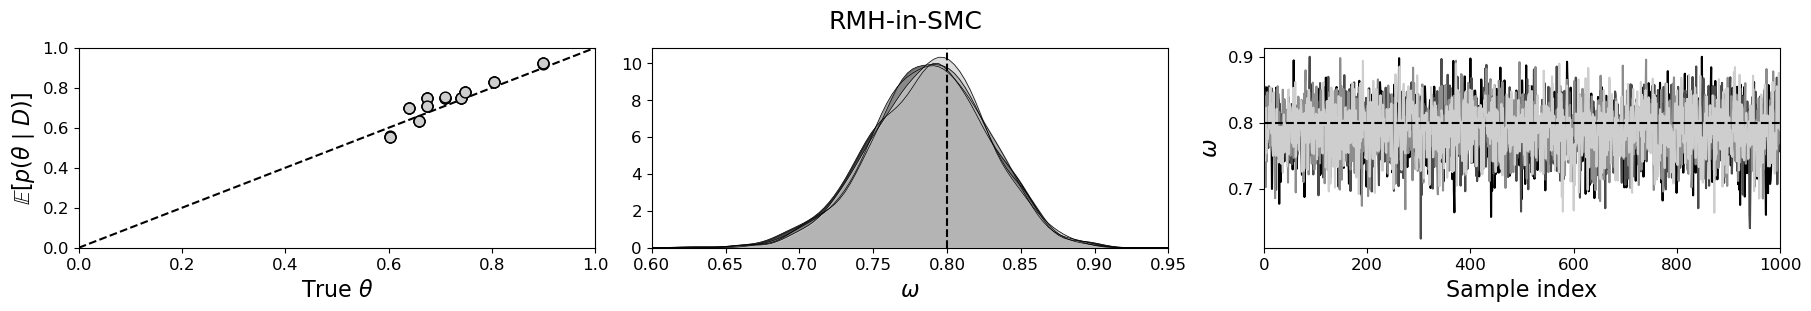

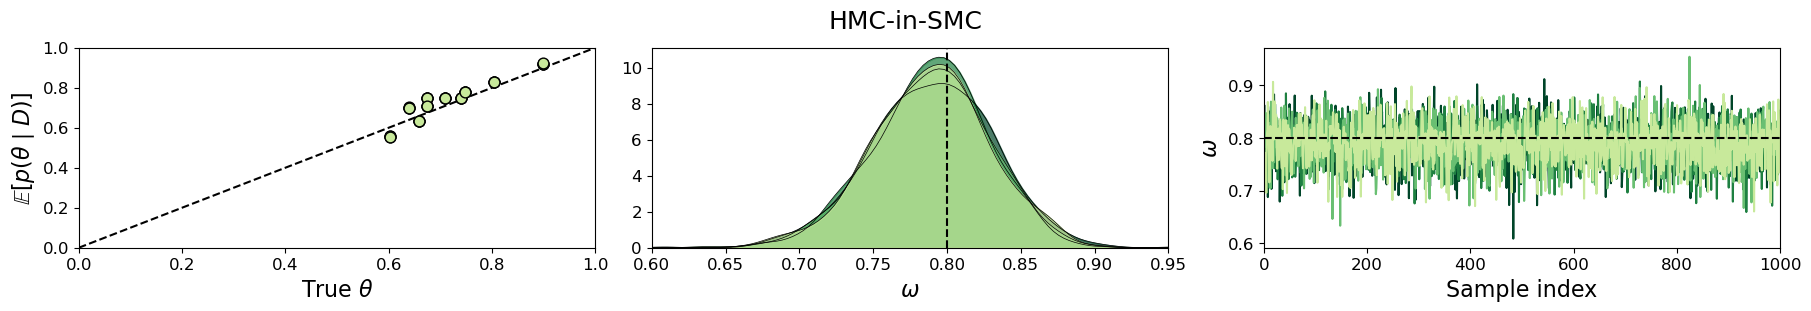

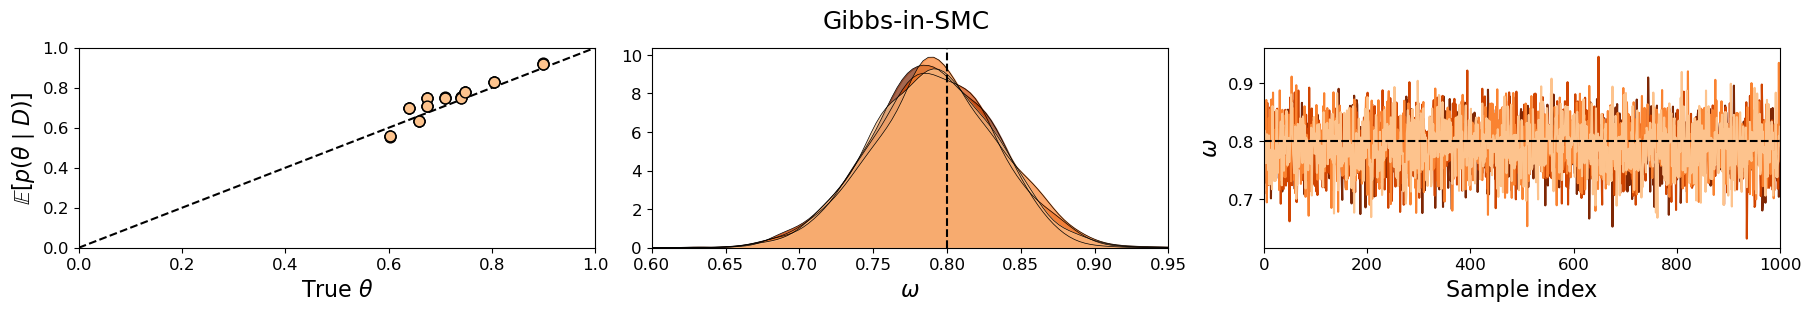

In [6]:
num_chains = 4
num_particles = 1_000
mcmc_settings = [dict(num_mcmc_steps=100),
                 dict(num_mcmc_steps=25),
                 dict(num_mcmc_steps=200)]

mcmc_colors = ['Greys', 'YlGn', 'Oranges']

for name, kernel, settings, color in zip(mcmc_names, mcmc_kernels, mcmc_settings, mcmc_colors):
    engine = SMCInference(model=model, num_chains=num_chains, return_diagnostics=True, mcmc_kernel=kernel, num_mutations=settings['num_mcmc_steps'], num_particles=num_particles)
    result = engine.run(key=jrnd.PRNGKey(0))
    plot_posterior(result['final_state'].particles, mpl.colormaps[color], title=f'{name}-in-SMC')
    ess = jax.tree_util.tree_map(effective_sample_size, result['final_state'].particles)
    print(f'Effective sample sizes for {name}')
    for variable, var_ess in ess.items():
        mean_ess = jnp.mean(var_ess)
        print(f'ESS ({variable}): {mean_ess:0.2f}')